In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

In [2]:
image_size = 256

In [9]:
# importing data

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '..\..\Data\Labeled',
    batch_size = 32,
    labels = 'inferred',                                              # get labels from folder structure
    class_names = ['pantry', 'bathroom', 'indoor', 'outdoor'],       # order of labels
    label_mode = 'int',
    shuffle = True,
    image_size = (image_size, image_size),
    crop_to_aspect_ratio = True
)

Found 3965 files belonging to 4 classes.


In [10]:
class_names = dataset.class_names
class_names

['pantry', 'bathroom', 'indoor', 'outdoor']

In [11]:
# taking one batch to inspect

for images, labels in dataset.take(1):
    print(images.shape)
    print(labels)

(32, 256, 256, 3)
tf.Tensor([3 3 1 1 3 2 2 3 2 2 1 3 3 3 3 3 3 0 3 0 3 1 3 2 2 2 3 0 2 2 2 1], shape=(32,), dtype=int32)


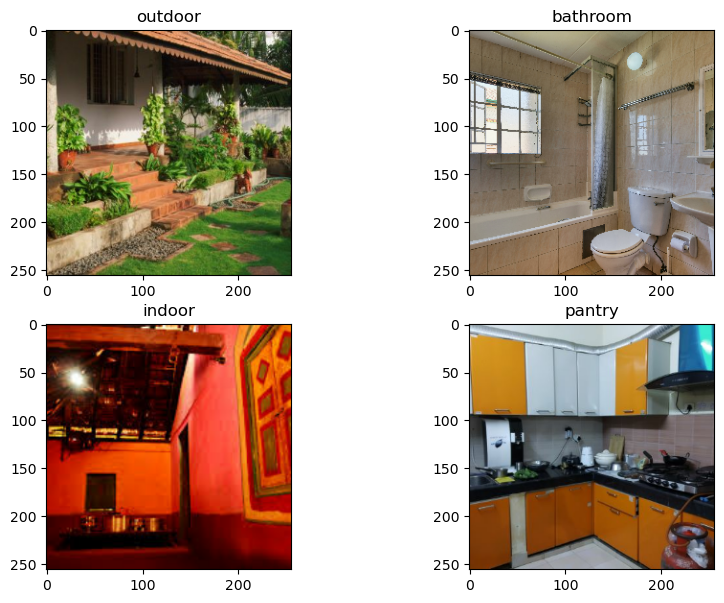

In [6]:
for images, labels in dataset.take(1):
    plt.figure(figsize = (10,7))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels.numpy()[i]])

In [139]:
# train, validation, test split

train_size = int(len(dataset) * 0.7)     # 70% for training, 15% for validation, 15% for test
val_size = int(len(dataset) * 0.15)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)
len(train_ds), len(val_ds), len(test_ds)

(84, 18, 18)

In [140]:
# setting caching and prefetching

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [141]:
# layers to resize, crop, rescale images (if there's any)

resize_and_crop = tf.keras.Sequential([
    layers.Resizing(image_size, image_size, crop_to_aspect_ratio = True)
])

rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

# augmentation

augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1)
])



In [150]:
model = tf.keras.Sequential([
    layers.Input((image_size, image_size, 3)),
    resize_and_crop,
    rescale,
    augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])


In [151]:
model.summary()

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_32 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_33 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_34 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,819,588 (26.01 MB)

 Trainable params: 6,819,588 (26.01 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [153]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks = [early_stopping],
    verbose = 1
)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 89s 996ms/step - accuracy: 0.5286 - loss: 1.3373 - val_accuracy: 0.6319 - val_loss: 0.9919
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6790 - loss: 0.9537 - val_accuracy: 0.6979 - val_loss: 0.8549
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 979ms/step - accuracy: 0.6992 - loss: 0.8618 - val_accuracy: 0.7083 - val_loss: 0.7798
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7077 - loss: 0.8113 - val_accuracy: 0.7222 - val_loss: 0.7013
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 83s 992ms/step - accuracy: 0.7240 - loss: 0.7579 - val_accuracy: 0.7500 - val_loss: 0.6795
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 954ms/step - accuracy: 0.7339 - loss: 0.7086 - val_accuracy: 0.7309 - val_loss: 0.7258
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7448 - loss: 0.7078 - val_accuracy: 0.7309 - val_loss: 0.6488
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 978ms/step - accuracy: 0.7565 - loss: 0.6770 - val_accuracy: 0.7

In [154]:
test_loss, test_acc = model.evaluate(test_ds)

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.8073 - loss: 0.5650


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


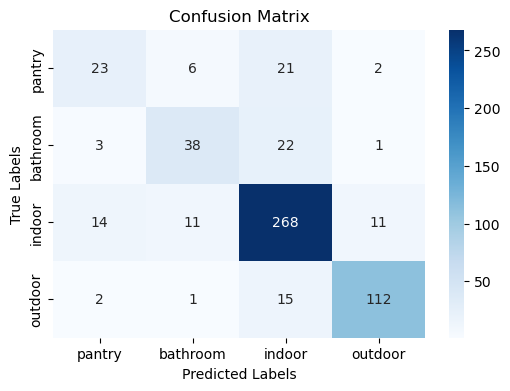

In [158]:
y_true = []
y_pred = []

for images, labels in test_ds:
    
    y_true.extend(labels.numpy())  # Convert from tensor to numpy array
    
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1) 
    y_pred.extend(predicted_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['pantry', 'bathroom', 'indoor', 'outdoor'], yticklabels=['pantry', 'bathroom', 'indoor', 'outdoor'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [160]:
model.save('house_image_model.keras')